In [49]:
import json
import numpy as np
from pathlib import Path
from typing import Dict, List, Any, Set, Tuple
import logging
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score as bert_score
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import defaultdict, Counter
import torch
from transformers import AutoTokenizer, AutoModel
import pickle

class RougeCalculator:
    """Custom implementation of ROUGE metrics"""
    
    @staticmethod
    def _get_ngrams(text: str, n: int) -> Counter:
        """Get n-gram counts from text"""
        tokens = word_tokenize(text.lower())
        ngrams = Counter()
        for i in range(len(tokens) - n + 1):
            ngram = tuple(tokens[i:i + n])
            ngrams[ngram] += 1
        return ngrams
        
    @staticmethod
    def _lcs(str1: List[str], str2: List[str]) -> int:
        """Calculate Longest Common Subsequence length"""
        m, n = len(str1), len(str2)
        dp = [[0] * (n + 1) for _ in range(m + 1)]
        
        for i in range(1, m + 1):
            for j in range(1, n + 1):
                if str1[i-1] == str2[j-1]:
                    dp[i][j] = dp[i-1][j-1] + 1
                else:
                    dp[i][j] = max(dp[i-1][j], dp[i][j-1])
        
        return dp[m][n]
    
    @staticmethod
    def calculate_rouge_scores(generated: str, reference: str) -> Dict[str, float]:
        """Calculate ROUGE-1, ROUGE-2, and ROUGE-L scores"""
        # Convert to lowercase and tokenize
        gen_tokens = word_tokenize(generated.lower())
        ref_tokens = word_tokenize(reference.lower())
        
        # Get n-grams
        gen_1grams = RougeCalculator._get_ngrams(generated, 1)
        ref_1grams = RougeCalculator._get_ngrams(reference, 1)
        gen_2grams = RougeCalculator._get_ngrams(generated, 2)
        ref_2grams = RougeCalculator._get_ngrams(reference, 2)
        
        # Calculate ROUGE-1
        overlap_1grams = sum((gen_1grams & ref_1grams).values())
        if len(gen_1grams) == 0:
            rouge1_precision = 0
        else:
            rouge1_precision = overlap_1grams / sum(gen_1grams.values())
            
        if len(ref_1grams) == 0:
            rouge1_recall = 0
        else:
            rouge1_recall = overlap_1grams / sum(ref_1grams.values())
            
        rouge1_f1 = (2 * rouge1_precision * rouge1_recall) / (rouge1_precision + rouge1_recall + 1e-8)
        
        # Calculate ROUGE-2
        overlap_2grams = sum((gen_2grams & ref_2grams).values())
        if len(gen_2grams) == 0:
            rouge2_precision = 0
        else:
            rouge2_precision = overlap_2grams / sum(gen_2grams.values())
            
        if len(ref_2grams) == 0:
            rouge2_recall = 0
        else:
            rouge2_recall = overlap_2grams / sum(ref_2grams.values())
            
        rouge2_f1 = (2 * rouge2_precision * rouge2_recall) / (rouge2_precision + rouge2_recall + 1e-8)
        
        # Calculate ROUGE-L
        lcs_length = RougeCalculator._lcs(gen_tokens, ref_tokens)
        if len(gen_tokens) == 0:
            rougeL_precision = 0
        else:
            rougeL_precision = lcs_length / len(gen_tokens)
            
        if len(ref_tokens) == 0:
            rougeL_recall = 0
        else:
            rougeL_recall = lcs_length / len(ref_tokens)
            
        rougeL_f1 = (2 * rougeL_precision * rougeL_recall) / (rougeL_precision + rougeL_recall + 1e-8)
        
        return {
            'rouge1_f': rouge1_f1,
            'rouge2_f': rouge2_f1,
            'rougeL_f': rougeL_f1
        }

class RAGEvaluator:
    def __init__(self, ground_truth_path: str, rag_results_path: str, output_dir: str = "rag_evaluation"):
        """Initialize RAG evaluator with paths to result files"""
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        
        logging.basicConfig(
            filename=self.output_dir / 'evaluation.log',
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)
        
        self.ground_truth = self._load_json(ground_truth_path)
        self.rag_results = self._load_json(rag_results_path)
        self.ground_truth_map = {item['question']: item['answer'] for item in self.ground_truth}
        
        try:
            nltk.download('punkt', quiet=True)
            nltk.download('wordnet', quiet=True)
        except Exception as e:
            self.logger.warning(f"NLTK download error: {str(e)}")
        
        self.rouge_calculator = RougeCalculator()
        self.bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = AutoModel.from_pretrained('bert-base-uncased')
        self.sim_model = SentenceTransformer('all-MiniLM-L6-v2')
            
    def _load_json(self, path: str) -> List[Dict]:
        """Load JSON file with error handling"""
        try:
            with open(path, 'r', encoding='utf-8') as f:
                return json.load(f)
        except Exception as e:
            self.logger.error(f"Error loading {path}: {str(e)}")
            raise
            
    def _save_checkpoint(self, results: Dict, name: str):
        """Save evaluation checkpoint"""
        checkpoint_path = self.output_dir / f"{name}_checkpoint.pkl"
        with open(checkpoint_path, 'wb') as f:
            pickle.dump(results, f)
        self.logger.info(f"Saved checkpoint: {checkpoint_path}")
            
    def calculate_text_metrics(self, generated: str, reference: str) -> Dict[str, float]:
        """Calculate BLEU, ROUGE scores"""
        try:
            # BLEU
            smoothie = SmoothingFunction().method1
            bleu_score = sentence_bleu(
                [word_tokenize(reference.lower())],
                word_tokenize(generated.lower()),
                smoothing_function=smoothie
            )
            
            # ROUGE (using custom implementation)
            rouge_scores = self.rouge_calculator.calculate_rouge_scores(generated, reference)
            
            return {
                'bleu': bleu_score,
                **rouge_scores
            }
        except Exception as e:
            self.logger.error(f"Error calculating text metrics: {str(e)}")
            return {'bleu': 0, 'rouge1_f': 0, 'rouge2_f': 0, 'rougeL_f': 0}
            
    def calculate_faithfulness(self, answer: str, retrieved_docs: List[Dict]) -> Dict[str, float]:
        """Calculate faithfulness and hallucination metrics"""
        try:
            # Combine all retrieved documents
            context = " ".join([doc['content'] for doc in retrieved_docs])
            
            # Tokenize answer and context
            answer_tokens = set(word_tokenize(answer.lower()))
            context_tokens = set(word_tokenize(context.lower()))
            
            # Calculate metrics
            supported_tokens = answer_tokens.intersection(context_tokens)
            hallucinated_tokens = answer_tokens - context_tokens
            
            if len(answer_tokens) == 0:
                return {'faithfulness': 0, 'hallucination_rate': 1.0}
            
            faithfulness = len(supported_tokens) / len(answer_tokens)
            hallucination_rate = len(hallucinated_tokens) / len(answer_tokens)
            
            return {
                'faithfulness': faithfulness,
                'hallucination_rate': hallucination_rate
            }
        except Exception as e:
            self.logger.error(f"Error calculating faithfulness: {str(e)}")
            return {'faithfulness': 0, 'hallucination_rate': 1.0}
            
    def calculate_coverage(self, answer: str, retrieved_docs: List[Dict]) -> float:
        """Calculate coverage using sentence embeddings similarity"""
        try:
            # Combine all retrieved documents
            context = " ".join([doc['content'] for doc in retrieved_docs])
            
            # Get embeddings
            answer_emb = self.sim_model.encode([answer])
            context_emb = self.sim_model.encode([context])
            
            # Calculate cosine similarity
            similarity = torch.nn.functional.cosine_similarity(
                torch.tensor(answer_emb), 
                torch.tensor(context_emb)
            ).item()
            
            return float(similarity)
        except Exception as e:
            self.logger.error(f"Error calculating coverage: {str(e)}")
            return 0.0
            
    def calculate_retrieval_metrics(self) -> Dict[str, float]:
        """Calculate average retrieval time and distance"""
        times = []
        distances = []
        
        for result in self.rag_results:
            if result.get('retrieval_time'):
                times.append(float(result['retrieval_time']))
            if result.get('avg_distance'):
                distances.append(float(result['avg_distance']))
                
        return {
            'avg_retrieval_time': np.mean(times) if times else 0,
            'avg_distance': np.mean(distances) if distances else 0
        }
        
    def evaluate(self) -> Dict[str, Any]:
        """Run full evaluation"""
        self.logger.info("Starting RAG evaluation...")
        
        results = {
            'per_query': [],
            'aggregated': defaultdict(list)
        }
        
        # Process each query
        for rag_result in tqdm(self.rag_results, desc="Evaluating queries"):
            question = rag_result['question']
            ground_truth = self.ground_truth_map.get(question)
            
            if not ground_truth:
                self.logger.warning(f"No ground truth found for question: {question[:50]}...")
                continue
                
            # Calculate metrics
            text_metrics = self.calculate_text_metrics(
                rag_result['answer'], 
                ground_truth
            )
            
            faithfulness_metrics = self.calculate_faithfulness(
                rag_result['answer'],
                rag_result['retrieved_docs']
            )
            
            coverage = self.calculate_coverage(
                rag_result['answer'],
                rag_result['retrieved_docs']
            )
            
            # Store results
            query_result = {
                'question': question,
                'metrics': {
                    **text_metrics,
                    **faithfulness_metrics,
                    'coverage': coverage
                }
            }
            
            results['per_query'].append(query_result)
            
            # Aggregate metrics
            for metric, value in query_result['metrics'].items():
                results['aggregated'][metric].append(value)
                
            # Save checkpoint periodically
            if len(results['per_query']) % 10 == 0:
                self._save_checkpoint(results, 'evaluation')
                
        # Calculate retrieval metrics
        retrieval_metrics = self.calculate_retrieval_metrics()
        results['retrieval_metrics'] = retrieval_metrics
        
        # Calculate final aggregated metrics
        results['final_metrics'] = {
            metric: float(np.mean(values))
            for metric, values in results['aggregated'].items()
        }
        
        # Save final results
        final_path = self.output_dir / "evaluation_results.json"
        with open(final_path, 'w', encoding='utf-8') as f:
            json.dump(results, f, indent=2)
            
        self.logger.info("Evaluation complete!")
        return results



In [21]:
# Example usage:

evaluator = RAGEvaluator(
    ground_truth_path='ground_truth.json',
    rag_results_path='hybrid_evaluation/qna_content.json',
    output_dir='rag_evaluation'
)
results = evaluator.evaluate()

# Print summary
print("\nFinal Metrics:")
for metric, value in results['final_metrics'].items():
    print(f"{metric}: {value:.4f}")

print("\nRetrieval Metrics:")
for metric, value in results['retrieval_metrics'].items():
    print(f"{metric}: {value:.4f}")


Evaluating queries:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating queries:   2%|█▌                                                             | 1/40 [00:00<00:14,  2.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating queries:   5%|███▏                                                           | 2/40 [00:00<00:15,  2.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating queries:   8%|████▋                                                          | 3/40 [00:01<00:15,  2.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating queries:  10%|██████▎                                                        | 4/40 [00:01<00:16,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating queries: 100%|██████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 20.03it/s]


Final Metrics:
bleu: 0.0105
rouge1_f: 0.1108
rouge2_f: 0.0415
rougeL_f: 0.0888
faithfulness: 0.4880
hallucination_rate: 0.5120
coverage: 0.6806

Retrieval Metrics:
avg_retrieval_time: 6.8266
avg_distance: 0.5459


In [22]:
# Example usage:

evaluator = RAGEvaluator(
    ground_truth_path='ground_truth.json',
    rag_results_path='hybrid_evaluation/qna_combined.json',
    output_dir='rag_evaluation'
)
results = evaluator.evaluate()

# Print summary
print("\nFinal Metrics:")
for metric, value in results['final_metrics'].items():
    print(f"{metric}: {value:.4f}")

print("\nRetrieval Metrics:")
for metric, value in results['retrieval_metrics'].items():
    print(f"{metric}: {value:.4f}")


Evaluating queries:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating queries:   2%|█▌                                                             | 1/40 [00:00<00:10,  3.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating queries:   5%|███▏                                                           | 2/40 [00:00<00:14,  2.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating queries:   8%|████▋                                                          | 3/40 [00:00<00:11,  3.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating queries:  10%|██████▎                                                        | 4/40 [00:01<00:10,  3.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating queries: 100%|██████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.36it/s]


Final Metrics:
bleu: 0.0040
rouge1_f: 0.0992
rouge2_f: 0.0214
rougeL_f: 0.0933
faithfulness: 0.4555
hallucination_rate: 0.5445
coverage: 0.0342

Retrieval Metrics:
avg_retrieval_time: 5.8719
avg_distance: 0.7510


In [8]:
import json
from pathlib import Path
from typing import Dict, List, Any
import logging

class RAGResultsPreprocessor:
    def __init__(self, input_path: str, output_dir: str = "preprocessed_data"):
        """Initialize preprocessor with paths"""
        self.input_path = Path(input_path)
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        
        # Setup logging
        logging.basicConfig(
            filename=self.output_dir / 'preprocessing.log',
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)
    
    def _load_json(self, path: str) -> List[Dict]:
        """Load JSON file with error handling"""
        try:
            with open(path, 'r', encoding='utf-8') as f:
                return json.load(f)
        except Exception as e:
            self.logger.error(f"Error loading {path}: {str(e)}")
            raise
    
    def _extract_qa_pairs(self, data: List[Dict]) -> List[Dict]:
        """Extract just Q&A pairs for ground truth"""
        qa_pairs = []
        for item in data:
            try:
                qa_pairs.append({
                    'question': item['question'],
                    'answer': item['answer'].split('###')[0].strip()  # Take only the main answer, before any headers
                })
            except Exception as e:
                self.logger.warning(f"Error processing QA pair: {str(e)}")
                continue
        return qa_pairs
    
    def _extract_rag_results(self, data: List[Dict]) -> List[Dict]:
        """Extract RAG results in the expected format"""
        rag_results = []
        for item in data:
            try:
                result = {
                    'question': item['question'],
                    'answer': item.get('answer', ''),
                    'retrieval_time': float(item.get('retrieval_time', 0)),
                    'avg_distance': float(item.get('avg_distance', 1.0)),
                    'retrieved_docs': []
                }
                
                # Process retrieved docs if present
                if 'retrieved_docs' in item:
                    for doc in item['retrieved_docs']:
                        result['retrieved_docs'].append({
                            'content': str(doc.get('content', '')),
                            'distance': float(doc.get('distance', 1.0)),
                            'chunk_id': str(doc.get('chunk_id', ''))
                        })
                
                rag_results.append(result)
            except Exception as e:
                self.logger.warning(f"Error processing RAG result: {str(e)}")
                continue
        
        return rag_results
    
    def preprocess(self) -> Dict[str, str]:
        """Preprocess the data and save both ground truth and RAG results"""
        try:
            # Load input data
            data = self._load_json(self.input_path)
            self.logger.info(f"Loaded {len(data)} items from {self.input_path}")
            
            # Extract and save ground truth
            qa_pairs = self._extract_qa_pairs(data)
            ground_truth_path = self.output_dir / "ground_truth.json"
            with open(ground_truth_path, 'w', encoding='utf-8') as f:
                json.dump(qa_pairs, f, indent=2, ensure_ascii=False)
            self.logger.info(f"Saved {len(qa_pairs)} QA pairs to {ground_truth_path}")
            
            # Extract and save RAG results
            rag_results = self._extract_rag_results(data)
            rag_results_path = self.output_dir / "rag_results.json"
            with open(rag_results_path, 'w', encoding='utf-8') as f:
                json.dump(rag_results, f, indent=2, ensure_ascii=False)
            self.logger.info(f"Saved {len(rag_results)} RAG results to {rag_results_path}")
            
            return {
                'ground_truth_path': str(ground_truth_path),
                'rag_results_path': str(rag_results_path)
            }
            
        except Exception as e:
            self.logger.error(f"Error during preprocessing: {str(e)}")
            raise



In [9]:
# Example usage:

# Initialize preprocessor
preprocessor = RAGResultsPreprocessor(
    input_path='hybrid_evaluation/qna_hybrid.json',
    output_dir='preprocessed_data'
)

# Preprocess data
paths = preprocessor.preprocess()

# Use the preprocessed data with the evaluator
evaluator = RAGEvaluator(
    ground_truth_path=paths['ground_truth_path'],
    rag_results_path=paths['rag_results_path'],
    output_dir='rag_evaluation'
)
results = evaluator.evaluate()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Evaluating queries:   0%|                                                                       | 0/40 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating queries:   2%|█▌                                                             | 1/40 [00:07<04:40,  7.20s/it]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.poo

Evaluating queries:  98%|████████████████████████████████████████████████████████████▍ | 39/40 [03:59<00:05,  5.44s/it]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating queries: 100%|██████████████████████████████████████████████████████████████| 40/40 [04:05<00:00,  6.14s/it]


In [10]:
# Print summary
print("\nFinal Metrics:")
for metric, value in results['final_metrics'].items():
    print(f"{metric}: {value:.4f}")

print("\nRetrieval Metrics:")
for metric, value in results['retrieval_metrics'].items():
    print(f"{metric}: {value:.4f}")


Final Metrics:
bleu: 0.3026
rouge1_f: 0.3608
rouge2_f: 0.3593
rougeL_f: 0.3608
faithfulness: 0.4075
hallucination_rate: 0.5925
coverage: 0.8204

Retrieval Metrics:
avg_retrieval_time: 14.1316
avg_distance: 0.8642


# Hallucination n Faithfullness

### by measuring the RAG answer against retreived chunks

In [1]:
import json
import nltk
from nltk.tokenize import word_tokenize
from pathlib import Path
import logging
from typing import Dict, List, Set
from tqdm import tqdm
import torch
from sentence_transformers import SentenceTransformer

class FaithfulnessCalculator:
    def __init__(self, rag_results_path: str):
        """Initialize calculator with path to RAG results"""
        self.rag_results_path = Path(rag_results_path)
        
        # Setup logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)
        
        self.sim_model = SentenceTransformer('all-MiniLM-L6-v2')
        
        # Initialize NLTK
        try:
            nltk.download('punkt', quiet=True)
        except Exception as e:
            self.logger.warning(f"NLTK download error: {str(e)}")
        
        # Common words to ignore
        self.stop_words = set(['i', 'cannot', 'find', 'the', 'answer', 'in', 'provided', 'context', 
                             'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'has', 'he',
                             'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the', 'to', 'was', 
                             'were', 'will', 'with', '.', ',', ':', ';', '(', ')', '[', ']'])
        
    def clean_text(self, text: str) -> Set[str]:
        """Clean and tokenize text, returning set of meaningful tokens"""
        # Convert to lowercase and tokenize
        tokens = word_tokenize(text.lower())
        
        # Remove stop words and punctuation, keep only meaningful words
        return {token for token in tokens 
                if token not in self.stop_words 
                and token.isalnum() 
                and len(token) > 1}  # Filter out single characters
    
    def calculate_metrics_for_response(self, 
                                     answer: str, 
                                     retrieved_docs: List[Dict]) -> Dict[str, float]:
        """Calculate faithfulness metrics for a single response"""
        # Handle "cannot find answer" case
        if "cannot find the answer in the provided context" in answer.lower():
            return {
                'faithfulness': 1.0,
                'hallucination_rate': 0.0,
                'supported_tokens': set(),
                'unsupported_tokens': set()
            }

        # Get answer tokens
        answer_tokens = self.clean_text(answer)
        
        # Get context tokens from all retrieved docs
        context = " ".join(doc['content'] for doc in retrieved_docs)
        context_tokens = self.clean_text(context)
        
        # Calculate supported and unsupported tokens
        supported_tokens = answer_tokens.intersection(context_tokens)
        unsupported_tokens = answer_tokens - context_tokens
        
        # Calculate metrics
        total_tokens = len(answer_tokens) if answer_tokens else 1
        faithfulness = len(supported_tokens) / total_tokens
        hallucination_rate = len(unsupported_tokens) / total_tokens
        
        return {
            'faithfulness': faithfulness,
            'hallucination_rate': hallucination_rate,
            'supported_tokens': supported_tokens,
            'unsupported_tokens': unsupported_tokens
        }
    
    def calculate_coverage(self, answer: str, retrieved_docs: List[Dict]) -> float:
        answer_tokens = set(word_tokenize(answer.lower()))
        coverage_scores = []

        for doc in retrieved_docs:
            doc_tokens = set(word_tokenize(doc['content'].lower()))
            score = len(answer_tokens.intersection(doc_tokens)) / len(answer_tokens)
            coverage_scores.append(score * doc.get('score', 1.0))  # Weight by relevance
        
        return max(coverage_scores) if coverage_scores else 0.0
    
    def analyze_rag_results(self) -> Dict:
        try:
            with open(self.rag_results_path, 'r', encoding='utf-8') as f:
                rag_results = json.load(f)

            self.logger.info(f"Loaded {len(rag_results)} RAG results")

            total_faithfulness = 0
            total_hallucination = 0
            total_coverage = 0
            results_with_details = []

            for result in tqdm(rag_results, desc="Analyzing responses"):
                metrics = self.calculate_metrics_for_response(
                    result['answer'],
                    result.get('retrieved_docs', [])
                )

                coverage = self.calculate_coverage(
                    result['answer'], 
                    result.get('retrieved_docs', [])
                )

                total_faithfulness += metrics['faithfulness']
                total_hallucination += metrics['hallucination_rate']
                total_coverage += coverage

                results_with_details.append({
                    'question': result['question'],
                    'metrics': {
                        'faithfulness': metrics['faithfulness'],
                        'hallucination_rate': metrics['hallucination_rate'],
                        'supported_count': len(metrics['supported_tokens']),
                        'unsupported_count': len(metrics['unsupported_tokens']),
                        'coverage': coverage
                    }
                })

            num_results = len(rag_results)
            avg_metrics = {
                'average_faithfulness': total_faithfulness / num_results,
                'average_hallucination': total_hallucination / num_results,
                'average_coverage': total_coverage / num_results
            }

            self.logger.info(f"Average Faithfulness: {avg_metrics['average_faithfulness']:.4f}")
            self.logger.info(f"Average Hallucination: {avg_metrics['average_hallucination']:.4f}")
            self.logger.info(f"Average Coverage: {avg_metrics['average_coverage']:.4f}")

            return {
                'summary': avg_metrics,
                'detailed_results': results_with_details
            }

        except Exception as e:
            self.logger.error(f"Error analyzing RAG results: {str(e)}")
            raise



C:\Users\prana\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [27]:

# Example usage:

calculator = FaithfulnessCalculator('hybrid_evaluation/qna_combined.json')
results = calculator.analyze_rag_results()

print("\nSummary Metrics:")
print(f"Average Faithfulness: {results['summary']['average_faithfulness']:.4f}")
print(f"Average Hallucination: {results['summary']['average_hallucination']:.4f}")
print(f"Average Coverage: {results['summary']['average_coverage']:.4f}")


Analyzing responses:   0%|                                                                      | 0/40 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:   2%|█▌                                                            | 1/40 [00:00<00:08,  4.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:   5%|███                                                           | 2/40 [00:00<00:13,  2.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:   8%|████▋                                                         | 3/40 [00:00<00:11,  3.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  10%|██████▏                                                       | 4/40 [00:01<00:10,  3.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  12%|███████▊                                                      | 5/40 [00:01<00:10,  3.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  15%|█████████▎                                                    | 6/40 [00:01<00:09,  3.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  18%|██████████▊                                                   | 7/40 [00:02<00:09,  3.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  20%|████████████▍                                                 | 8/40 [00:02<00:08,  3.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  22%|█████████████▉                                                | 9/40 [00:02<00:09,  3.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  25%|███████████████▎                                             | 10/40 [00:02<00:08,  3.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  28%|████████████████▊                                            | 11/40 [00:03<00:09,  3.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  30%|██████████████████▎                                          | 12/40 [00:03<00:08,  3.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  32%|███████████████████▊                                         | 13/40 [00:04<00:09,  2.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  35%|█████████████████████▎                                       | 14/40 [00:04<00:08,  3.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  38%|██████████████████████▉                                      | 15/40 [00:04<00:07,  3.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  40%|████████████████████████▍                                    | 16/40 [00:04<00:06,  3.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  42%|█████████████████████████▉                                   | 17/40 [00:05<00:06,  3.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  45%|███████████████████████████▍                                 | 18/40 [00:05<00:06,  3.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  48%|████████████████████████████▉                                | 19/40 [00:05<00:06,  3.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  50%|██████████████████████████████▌                              | 20/40 [00:06<00:06,  3.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  52%|████████████████████████████████                             | 21/40 [00:06<00:06,  2.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  55%|█████████████████████████████████▌                           | 22/40 [00:06<00:06,  2.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  57%|███████████████████████████████████                          | 23/40 [00:07<00:05,  3.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  60%|████████████████████████████████████▌                        | 24/40 [00:07<00:04,  3.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  62%|██████████████████████████████████████▏                      | 25/40 [00:07<00:04,  3.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  65%|███████████████████████████████████████▋                     | 26/40 [00:07<00:03,  3.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  68%|█████████████████████████████████████████▏                   | 27/40 [00:08<00:03,  3.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  70%|██████████████████████████████████████████▋                  | 28/40 [00:08<00:03,  3.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  72%|████████████████████████████████████████████▏                | 29/40 [00:08<00:02,  3.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  75%|█████████████████████████████████████████████▊               | 30/40 [00:08<00:02,  3.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  78%|███████████████████████████████████████████████▎             | 31/40 [00:09<00:02,  4.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  80%|████████████████████████████████████████████████▊            | 32/40 [00:09<00:01,  4.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  82%|██████████████████████████████████████████████████▎          | 33/40 [00:09<00:01,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  85%|███████████████████████████████████████████████████▊         | 34/40 [00:09<00:01,  3.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  88%|█████████████████████████████████████████████████████▍       | 35/40 [00:10<00:01,  3.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  90%|██████████████████████████████████████████████████████▉      | 36/40 [00:10<00:01,  3.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  92%|████████████████████████████████████████████████████████▍    | 37/40 [00:10<00:00,  3.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  95%|█████████████████████████████████████████████████████████▉   | 38/40 [00:11<00:00,  3.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  98%|███████████████████████████████████████████████████████████▍ | 39/40 [00:11<00:00,  3.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.48it/s]


Summary Metrics:
Average Faithfulness: 0.8691
Average Hallucination: 0.1309
Average Coverage: 0.2031


In [29]:

# Example usage:

calculator = FaithfulnessCalculator('hybrid_evaluation/qna_content.json')
results = calculator.analyze_rag_results()

print("\nSummary Metrics:")
print(f"Average Faithfulness: {results['summary']['average_faithfulness']:.4f}")
print(f"Average Hallucination: {results['summary']['average_hallucination']:.4f}")
print(f"Average Coverage: {results['summary']['average_coverage']:.4f}")


Analyzing responses:   0%|                                                                      | 0/40 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:   2%|█▌                                                            | 1/40 [00:00<00:13,  2.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:   5%|███                                                           | 2/40 [00:00<00:14,  2.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:   8%|████▋                                                         | 3/40 [00:01<00:14,  2.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  10%|██████▏                                                       | 4/40 [00:01<00:13,  2.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  12%|███████▊                                                      | 5/40 [00:01<00:11,  3.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  15%|█████████▎                                                    | 6/40 [00:02<00:10,  3.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  18%|██████████▊                                                   | 7/40 [00:02<00:09,  3.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  20%|████████████▍                                                 | 8/40 [00:02<00:08,  3.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  22%|█████████████▉                                                | 9/40 [00:02<00:09,  3.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  25%|███████████████▎                                             | 10/40 [00:03<00:08,  3.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  28%|████████████████▊                                            | 11/40 [00:03<00:08,  3.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  30%|██████████████████▎                                          | 12/40 [00:03<00:08,  3.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  32%|███████████████████▊                                         | 13/40 [00:04<00:08,  3.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  35%|█████████████████████▎                                       | 14/40 [00:04<00:07,  3.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  38%|██████████████████████▉                                      | 15/40 [00:04<00:07,  3.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  40%|████████████████████████▍                                    | 16/40 [00:04<00:07,  3.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  42%|█████████████████████████▉                                   | 17/40 [00:05<00:07,  3.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  45%|███████████████████████████▍                                 | 18/40 [00:05<00:06,  3.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  48%|████████████████████████████▉                                | 19/40 [00:05<00:05,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  50%|██████████████████████████████▌                              | 20/40 [00:06<00:05,  3.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  52%|████████████████████████████████                             | 21/40 [00:06<00:05,  3.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  55%|█████████████████████████████████▌                           | 22/40 [00:06<00:04,  3.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  57%|███████████████████████████████████                          | 23/40 [00:06<00:04,  3.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  60%|████████████████████████████████████▌                        | 24/40 [00:07<00:04,  3.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  62%|██████████████████████████████████████▏                      | 25/40 [00:07<00:04,  3.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  65%|███████████████████████████████████████▋                     | 26/40 [00:07<00:03,  3.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  68%|█████████████████████████████████████████▏                   | 27/40 [00:07<00:03,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  70%|██████████████████████████████████████████▋                  | 28/40 [00:08<00:03,  3.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  72%|████████████████████████████████████████████▏                | 29/40 [00:08<00:03,  3.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  75%|█████████████████████████████████████████████▊               | 30/40 [00:08<00:03,  3.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  78%|███████████████████████████████████████████████▎             | 31/40 [00:09<00:02,  3.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  80%|████████████████████████████████████████████████▊            | 32/40 [00:09<00:02,  3.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  82%|██████████████████████████████████████████████████▎          | 33/40 [00:09<00:02,  3.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  85%|███████████████████████████████████████████████████▊         | 34/40 [00:10<00:01,  3.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  88%|█████████████████████████████████████████████████████▍       | 35/40 [00:10<00:01,  3.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  90%|██████████████████████████████████████████████████████▉      | 36/40 [00:10<00:01,  3.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  92%|████████████████████████████████████████████████████████▍    | 37/40 [00:11<00:00,  3.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  95%|█████████████████████████████████████████████████████████▉   | 38/40 [00:11<00:00,  3.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  98%|███████████████████████████████████████████████████████████▍ | 39/40 [00:11<00:00,  3.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.36it/s]


Summary Metrics:
Average Faithfulness: 0.6282
Average Hallucination: 0.3718
Average Coverage: 0.6131


In [30]:

# Example usage:

calculator = FaithfulnessCalculator('hybrid_evaluation/qna_hybrid.json')
results = calculator.analyze_rag_results()

print("\nSummary Metrics:")
print(f"Average Faithfulness: {results['summary']['average_faithfulness']:.4f}")
print(f"Average Hallucination: {results['summary']['average_hallucination']:.4f}")
print(f"Average Coverage: {results['summary']['average_coverage']:.4f}")


Analyzing responses:   0%|                                                                      | 0/40 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:   2%|█▌                                                            | 1/40 [00:00<00:12,  3.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:   5%|███                                                           | 2/40 [00:00<00:13,  2.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:   8%|████▋                                                         | 3/40 [00:01<00:14,  2.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  10%|██████▏                                                       | 4/40 [00:01<00:14,  2.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  12%|███████▊                                                      | 5/40 [00:01<00:13,  2.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  15%|█████████▎                                                    | 6/40 [00:02<00:12,  2.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  18%|██████████▊                                                   | 7/40 [00:02<00:12,  2.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  20%|████████████▍                                                 | 8/40 [00:02<00:11,  2.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  22%|█████████████▉                                                | 9/40 [00:03<00:10,  2.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  25%|███████████████▎                                             | 10/40 [00:03<00:10,  2.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  28%|████████████████▊                                            | 11/40 [00:03<00:09,  2.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  30%|██████████████████▎                                          | 12/40 [00:04<00:09,  2.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  32%|███████████████████▊                                         | 13/40 [00:04<00:09,  2.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  35%|█████████████████████▎                                       | 14/40 [00:04<00:08,  2.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  38%|██████████████████████▉                                      | 15/40 [00:05<00:08,  2.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  40%|████████████████████████▍                                    | 16/40 [00:05<00:08,  2.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  42%|█████████████████████████▉                                   | 17/40 [00:05<00:07,  2.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  45%|███████████████████████████▍                                 | 18/40 [00:06<00:07,  2.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  48%|████████████████████████████▉                                | 19/40 [00:06<00:07,  2.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  50%|██████████████████████████████▌                              | 20/40 [00:06<00:06,  3.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  52%|████████████████████████████████                             | 21/40 [00:07<00:06,  3.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  55%|█████████████████████████████████▌                           | 22/40 [00:07<00:05,  3.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  57%|███████████████████████████████████                          | 23/40 [00:07<00:05,  3.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  60%|████████████████████████████████████▌                        | 24/40 [00:08<00:05,  2.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  62%|██████████████████████████████████████▏                      | 25/40 [00:08<00:05,  2.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  65%|███████████████████████████████████████▋                     | 26/40 [00:09<00:04,  2.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  68%|█████████████████████████████████████████▏                   | 27/40 [00:09<00:04,  2.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  70%|██████████████████████████████████████████▋                  | 28/40 [00:09<00:04,  2.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  72%|████████████████████████████████████████████▏                | 29/40 [00:10<00:03,  2.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  75%|█████████████████████████████████████████████▊               | 30/40 [00:10<00:03,  3.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  78%|███████████████████████████████████████████████▎             | 31/40 [00:10<00:02,  3.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  80%|████████████████████████████████████████████████▊            | 32/40 [00:10<00:02,  3.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  82%|██████████████████████████████████████████████████▎          | 33/40 [00:11<00:02,  3.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  85%|███████████████████████████████████████████████████▊         | 34/40 [00:11<00:01,  3.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  88%|█████████████████████████████████████████████████████▍       | 35/40 [00:11<00:01,  3.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  90%|██████████████████████████████████████████████████████▉      | 36/40 [00:12<00:01,  2.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  92%|████████████████████████████████████████████████████████▍    | 37/40 [00:12<00:01,  2.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  95%|█████████████████████████████████████████████████████████▉   | 38/40 [00:13<00:00,  2.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses:  98%|███████████████████████████████████████████████████████████▍ | 39/40 [00:13<00:00,  2.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing responses: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:14<00:00,  2.82it/s]


Summary Metrics:
Average Faithfulness: 0.3773
Average Hallucination: 0.6227
Average Coverage: 0.7460


In [2]:

# Example usage:

calculator = FaithfulnessCalculator('hybrid_evaluation/qna_combined_elastic.json')
results = calculator.analyze_rag_results()

print("\nSummary Metrics:")
print(f"Average Faithfulness: {results['summary']['average_faithfulness']:.4f}")
print(f"Average Hallucination: {results['summary']['average_hallucination']:.4f}")
print(f"Average Coverage: {results['summary']['average_coverage']:.4f}")


2025-03-04 21:55:55,084 - INFO - Use pytorch device_name: cpu
2025-03-04 21:55:55,085 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
C:\Users\prana\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
2025-03-04 21:55:56,919 - INFO - Loaded 40 RAG results
Analyzing responses: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 77.93it/s]
2025-03-04 21:55:57,434 - INFO - Average Faithfulness: 0.4409
2025-03-04 21:55:57,435 - INFO - Average Hallucination: 0.5591
2025-03-04 21:55:57,435 - INFO - Average Coverage: 0.3565



Summary Metrics:
Average Faithfulness: 0.4409
Average Hallucination: 0.5591
Average Coverage: 0.3565


In [16]:
import json
import numpy as np
from pathlib import Path
from typing import Dict, List, Any
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
import nltk
import logging
import torch
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import pickle
from collections import defaultdict, Counter

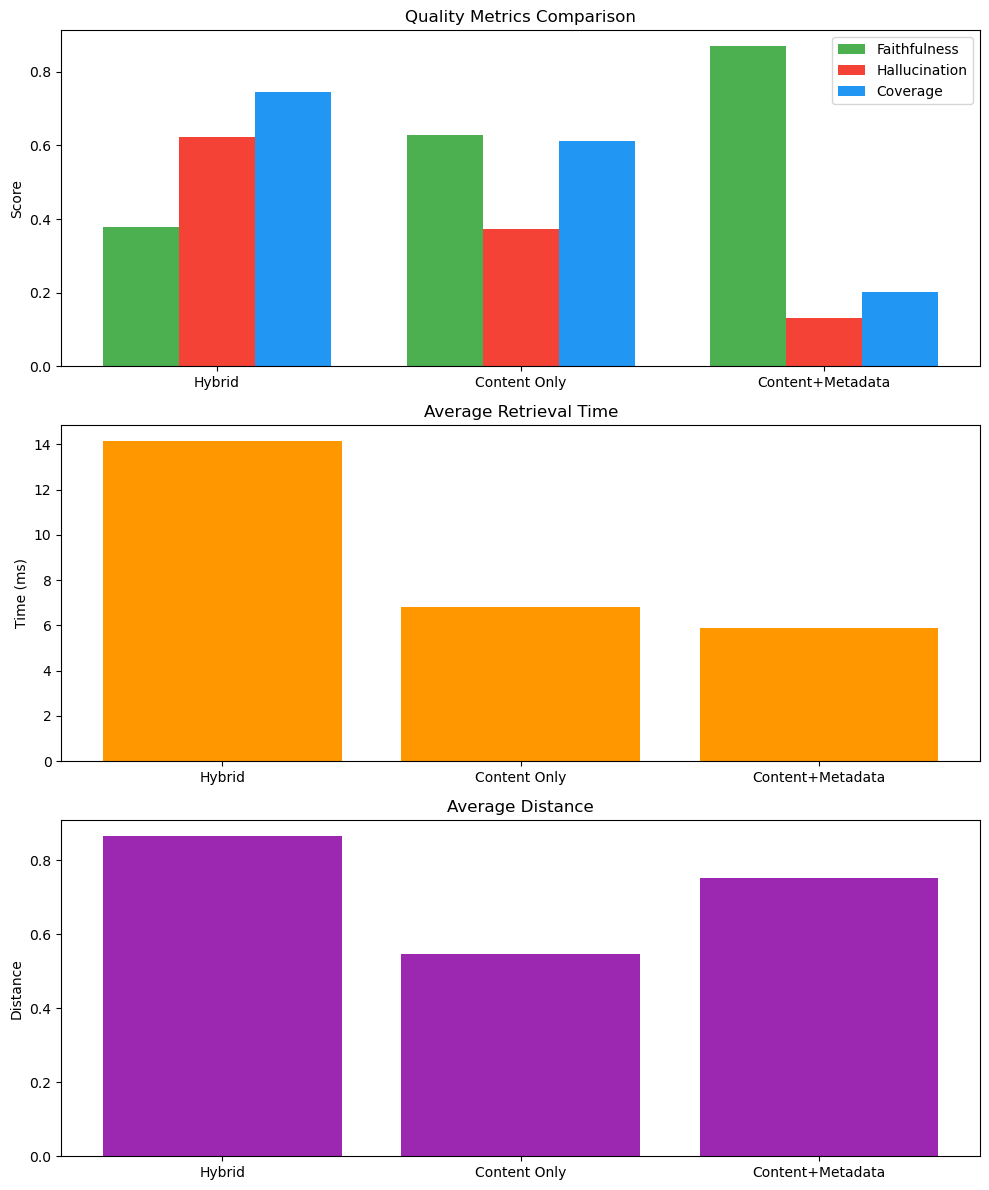

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Data
methods = ['Hybrid', 'Content Only', 'Content+Metadata']
faithfulness = [0.3773, 0.6282, 0.8691]
hallucination = [0.6227, 0.3718, 0.1309] 
coverage = [0.7460, 0.6131, 0.2031]
retrieval_time = [14.1316, 6.8266, 5.8719]
distance = [0.8642, 0.5459, 0.7510]

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Quality Metrics
x = np.arange(len(methods))
width = 0.25

ax1.bar(x - width, faithfulness, width, label='Faithfulness', color='#4CAF50')
ax1.bar(x, hallucination, width, label='Hallucination', color='#f44336')
ax1.bar(x + width, coverage, width, label='Coverage', color='#2196F3')
ax1.set_ylabel('Score')
ax1.set_title('Quality Metrics Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.legend()

# Plot 2: Retrieval Time
ax2.bar(methods, retrieval_time, color='#FF9800')
ax2.set_ylabel('Time (ms)')
ax2.set_title('Average Retrieval Time')

# Plot 3: Distance
ax3.bar(methods, distance, color='#9C27B0')
ax3.set_ylabel('Distance')
ax3.set_title('Average Distance')

plt.tight_layout()
plt.show()

C:\Users\prana\AppData\Local\Temp\ipykernel_44652\1482636278.py:13: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



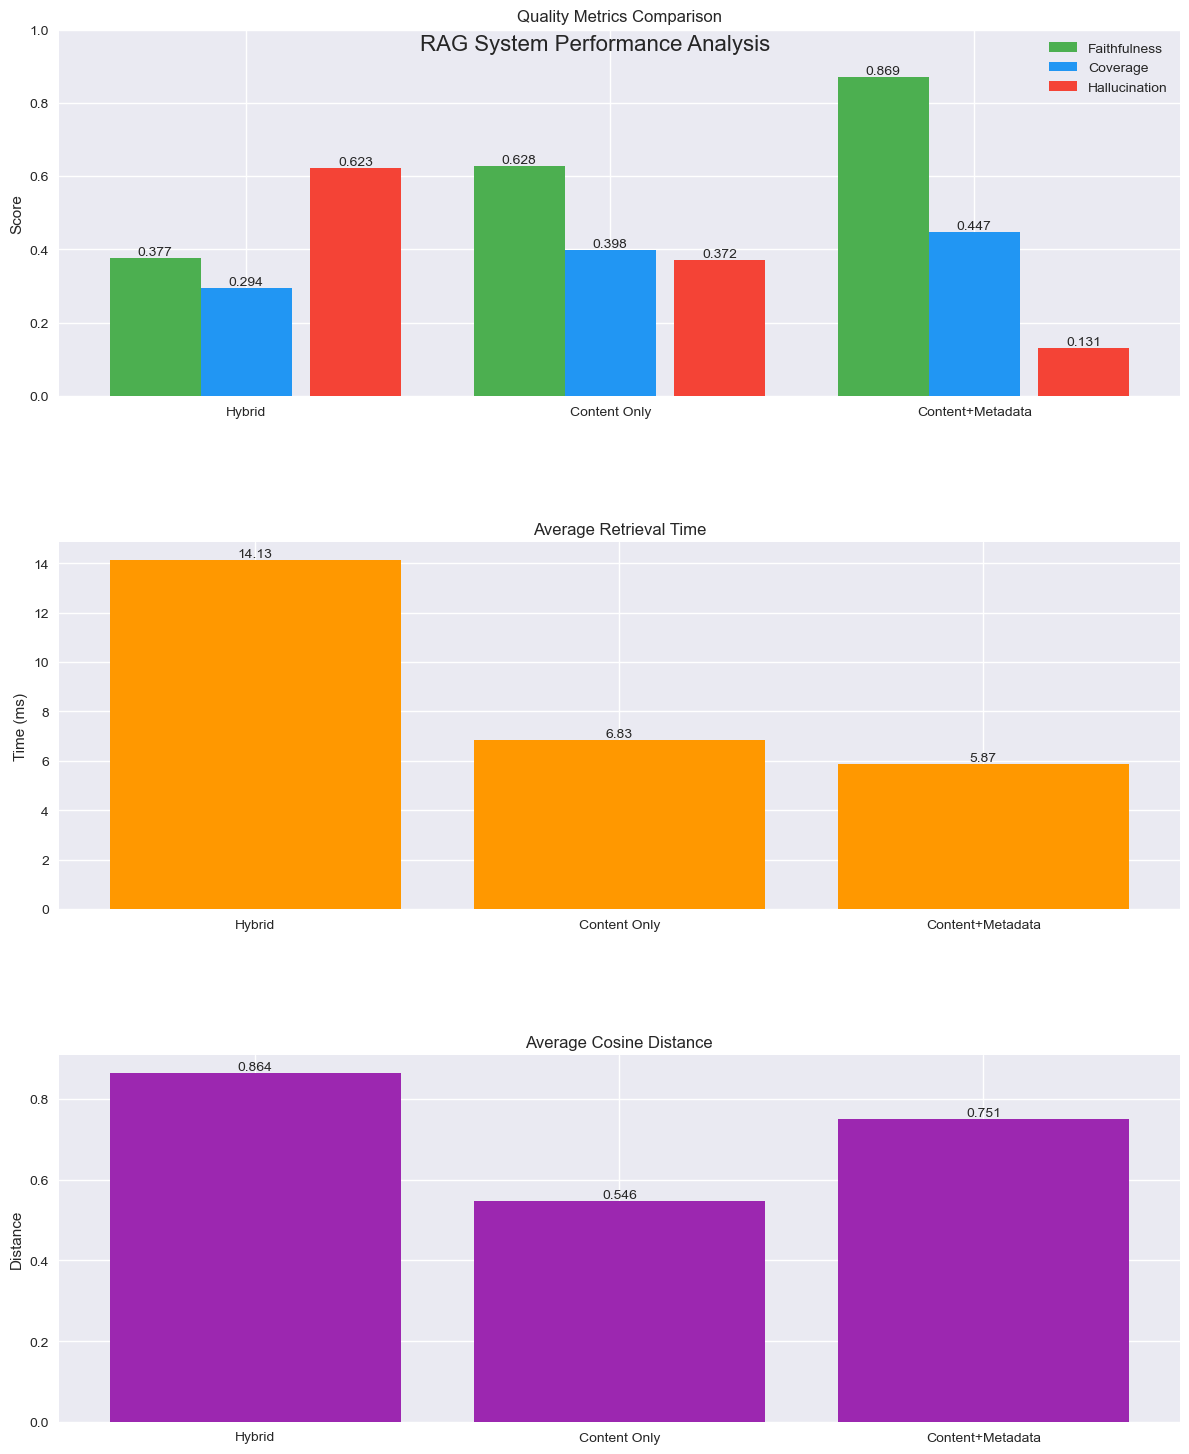

In [66]:

import matplotlib.pyplot as plt
import numpy as np

# Data
methods = ['Hybrid', 'Content Only', 'Content+Metadata']
faithfulness = [0.3773, 0.6282, 0.8691]
hallucination = [0.6227, 0.3718, 0.1309]
coverage = [0.2943, 0.3982, 0.4474]
retrieval_time = [14.1316, 6.8266, 5.8719]
distance = [0.8642, 0.5459, 0.7510]

# Set style and figure size
plt.style.use('seaborn')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
fig.suptitle('RAG System Performance Analysis', fontsize=16, y=0.95)

# Plot 1: Quality Metrics
# Plot 1: Quality Metrics
x = np.arange(len(methods))
width = 0.25

bars1 = ax1.bar(x - width, faithfulness, width, label='Faithfulness', color='#4CAF50')
bars2 = ax1.bar(x, coverage, width, label='Coverage', color='#2196F3')
bars3 = ax1.bar(x + 1.2*width, hallucination, width, label='Hallucination', color='#f44336')

ax1.set_ylabel('Score') 
ax1.set_title('Quality Metrics Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.legend()
ax1.set_ylim(0, 1.0)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')

# Plot 2: Retrieval Time
bars4 = ax2.bar(methods, retrieval_time, color='#FF9800')
ax2.set_ylabel('Time (ms)')
ax2.set_title('Average Retrieval Time')
for bar in bars4:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom')

# Plot 3: Distance
bars5 = ax3.bar(methods, distance, color='#9C27B0')
ax3.set_ylabel('Distance')
ax3.set_title('Average Cosine Distance')
for bar in bars5:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()


# Add captions as text boxes
Figure 1: Quality metrics comparison showing faithfulness (token overlap with context), hallucination\n' 
         'rate (tokens not found in context), and semantic coverage between response and context. Results demonstrate\n'
         'Content+Metadata achieves superior faithfulness while Hybrid maintains better coverage.', fontsize=13, ha='left', wrap=True)

Figure 2: Processing efficiency measured through retrieval times. Hybrid search requires approximately\n'
         'twice the processing time compared to other approaches, likely due to the overhead of combining multiple\n'
         'search strategies.', fontsize=13, ha='left', wrap=True)

Figure 3: Average cosine distance between queries and retrieved documents. Higher distances in Hybrid\n'
         'and Content+Metadata suggest more diverse results, while Content Only shows tighter semantic alignment\n'
         'between queries and documents.', fontsize=13, ha='left', wrap=True)

In [60]:

# Example usage:

calculator = FaithfulnessCalculator('hybrid_evaluation/qna_combined.json')
results = calculator.analyze_rag_results()

print("\nSummary Metrics:")
print(f"Average Faithfulness: {results['summary']['average_faithfulness']:.4f}")
print(f"Average Hallucination: {results['summary']['average_hallucination']:.4f}")
print(f"Average Coverage: {results['summary']['average_coverage']:.4f}")


Analyzing responses: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 99.71it/s]


Summary Metrics:
Average Faithfulness: 0.8691
Average Hallucination: 0.1309
Average Coverage: 0.4474


In [61]:

# Example usage:

calculator = FaithfulnessCalculator('hybrid_evaluation/qna_content.json')
results = calculator.analyze_rag_results()

print("\nSummary Metrics:")
print(f"Average Faithfulness: {results['summary']['average_faithfulness']:.4f}")
print(f"Average Hallucination: {results['summary']['average_hallucination']:.4f}")
print(f"Average Coverage: {results['summary']['average_coverage']:.4f}")


Analyzing responses: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.62it/s]


Summary Metrics:
Average Faithfulness: 0.6282
Average Hallucination: 0.3718
Average Coverage: 0.3982


In [62]:

# Example usage:

calculator = FaithfulnessCalculator('hybrid_evaluation/qna_hybrid.json')
results = calculator.analyze_rag_results()

print("\nSummary Metrics:")
print(f"Average Faithfulness: {results['summary']['average_faithfulness']:.4f}")
print(f"Average Hallucination: {results['summary']['average_hallucination']:.4f}")
print(f"Average Coverage: {results['summary']['average_coverage']:.4f}")


Analyzing responses: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 40.44it/s]


Summary Metrics:
Average Faithfulness: 0.3773
Average Hallucination: 0.6227
Average Coverage: 0.2943
